In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

2023-02-28 15:43:04.249732: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 15:43:05.224191: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/francesco/Downloads/cuda/lib64:/usr/local/cuda-11.2/lib64
2023-02-28 15:43:05.224262: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/francesco/Downloads/cuda/lib64:/usr/local/cuda-11.2/lib64
20

### Load data 

In [2]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


### Display sample

[8]


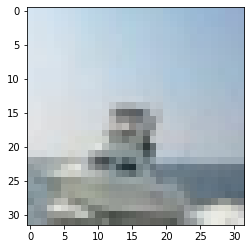

In [3]:
index = 100
plt.imshow(X_train[index])
print(Y_train[index])

### Load layer to preprocess inputs

In [4]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

### Load pretrained network without final part

In [5]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.VGG16(input_shape=X_train.shape[1:], include_top=False, weights='imagenet')
base_model.trainable = False
base_model.summary()

2023-02-28 15:43:08.417404: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-28 15:43:08.422576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-28 15:43:08.422918: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-28 15:43:08.423620: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

### Add final layers

In [6]:
flatten = tf.keras.layers.Flatten()
dense = tf.keras.layers.Dense(64, activation="relu")
final = tf.keras.layers.Dense(10, activation="softmax")

### Put everything together

In [7]:
inputs = tf.keras.Input(shape=X_train.shape[1:])
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = flatten(x)
x = dense(x)
outputs = final(x)
model = tf.keras.Model(inputs, outputs)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 32, 32, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 32, 32, 3)        0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                             

### Train only final layers (classification), feature extraction is untouched / frozen

In [8]:
history = model.fit(X_train, Y_train, batch_size=128, validation_data=(X_test, Y_test), epochs=100)

Epoch 1/100


2023-02-28 15:43:11.701923: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-28 15:43:14.449914: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1f0b7310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-28 15:43:14.449943: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2023-02-28 15:43:14.455869: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-28 15:43:14.620420: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


391/391 [==============================] - 19s 36ms/step - loss: 7.4397 - accuracy: 0.2902 - val_loss: 4.3307 - val_accuracy: 0.3823
Epoch 2/100
391/391 [==============================] - 12s 31ms/step - loss: 3.3857 - accuracy: 0.4169 - val_loss: 2.8711 - val_accuracy: 0.4290
Epoch 3/100
391/391 [==============================] - 12s 31ms/step - loss: 2.3911 - accuracy: 0.4477 - val_loss: 2.2204 - val_accuracy: 0.4482
Epoch 4/100
391/391 [==============================] - 12s 31ms/step - loss: 1.9257 - accuracy: 0.4676 - val_loss: 1.8918 - val_accuracy: 0.4635
Epoch 5/100
391/391 [==============================] - 12s 31ms/step - loss: 1.6851 - accuracy: 0.4910 - val_loss: 1.7150 - val_accuracy: 0.4846
Epoch 6/100
391/391 [==============================] - 12s 31ms/step - loss: 1.5378 - accuracy: 0.5142 - val_loss: 1.5944 - val_accuracy: 0.5055
Epoch 7/100
391/391 [==============================] - 12s 31ms/step - loss: 1.4318 - accuracy: 0.5349 - val_loss: 1.5145 - val_accuracy: 0.52

391/391 [==============================] - 12s 29ms/step - loss: 0.6218 - accuracy: 0.7845 - val_loss: 1.2675 - val_accuracy: 0.6350
Epoch 58/100
391/391 [==============================] - 12s 29ms/step - loss: 0.6178 - accuracy: 0.7864 - val_loss: 1.2696 - val_accuracy: 0.6360
Epoch 59/100
391/391 [==============================] - 12s 29ms/step - loss: 0.6133 - accuracy: 0.7874 - val_loss: 1.2781 - val_accuracy: 0.6358
Epoch 60/100
391/391 [==============================] - 12s 30ms/step - loss: 0.6093 - accuracy: 0.7890 - val_loss: 1.2881 - val_accuracy: 0.6349
Epoch 61/100
391/391 [==============================] - 12s 31ms/step - loss: 0.6050 - accuracy: 0.7910 - val_loss: 1.2931 - val_accuracy: 0.6341
Epoch 62/100
391/391 [==============================] - 12s 31ms/step - loss: 0.6011 - accuracy: 0.7922 - val_loss: 1.2964 - val_accuracy: 0.6358
Epoch 63/100
391/391 [==============================] - 12s 30ms/step - loss: 0.5967 - accuracy: 0.7939 - val_loss: 1.3071 - val_accuracy

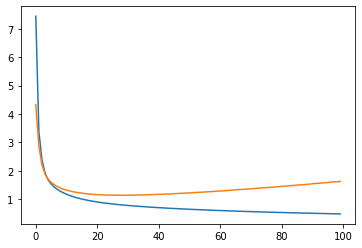

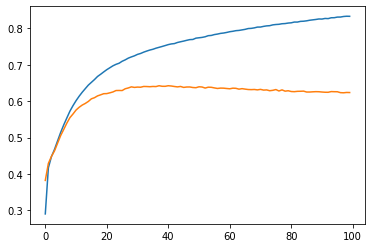

In [12]:
# Plot losses
plt.plot(range(len(history.history["loss"])), history.history["loss"])
plt.plot(range(len(history.history["val_loss"])), history.history["val_loss"])
plt.show()

# Plot accuracies
plt.plot(range(len(history.history["accuracy"])), history.history["accuracy"])
plt.plot(range(len(history.history["val_accuracy"])), history.history["val_accuracy"])
plt.show()